<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/compara%C3%A7%C3%B5es_entre_OMP_e_Cosamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

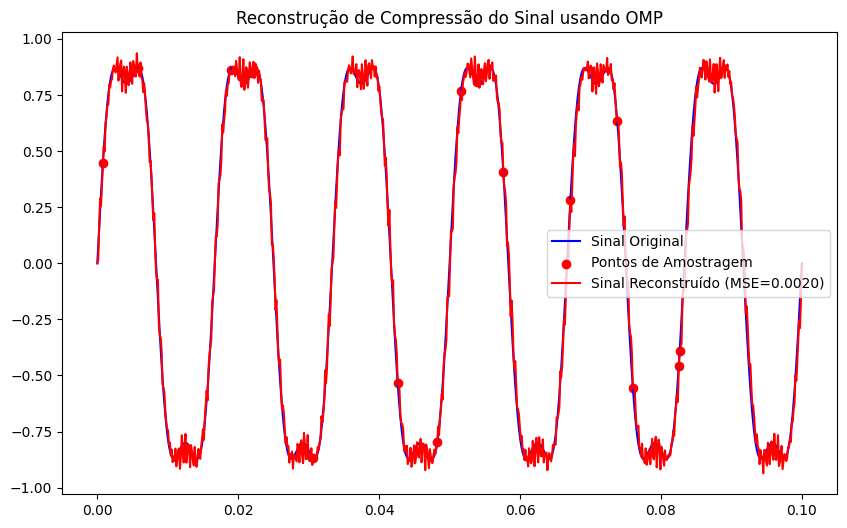

In [1]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

#n = 4000  # número de medições
n = 6*128
t = np.linspace(0.0, 0.1, num=n)

# Sinal original
#x = np.sin(91 * 2 * np.pi * t) + np.sin(412 * 2 * np.pi * t)
x = np.sin(60* 2 * np.pi * t) + 0.2*np.sin(180 * 2 * np.pi * t)

# amostragem aleatória do sinal
p = 15  # amostragem aleatória (Note que isso é um oitavo da taxa de Shannon–Nyquist!)
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = x[amostras_aleatorias]  # nossa medição comprimida a partir da amostragem aleatória

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa

#Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
Phi = np.fft.fft(np.eye(n,n)) * 1
CPhi = np.imag(Phi[amostras_aleatorias, :])

# OMP para minimização de l1
s_reconstruido = omp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo OMP
#x_rec = scipy.fftpack.idct(s_reconstruido, axis=0, norm='ortho')  # Sinal reconstruído
x_rec = np.imag(np.fft.fft(s_reconstruido))
# Calcular o MSE
mse_omp = calculate_mse(x, x_rec)

# Visualizar o sinal original com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
plt.plot(t, x, 'b', label='Sinal Original')
plt.scatter(t[amostras_aleatorias], x[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec, 'r', label=f'Sinal Reconstruído (MSE={mse_omp:.4f})')
#plt.xlim(0.4, 0.5)
plt.title('Reconstrução de Compressão do Sinal usando OMP')
plt.legend()
plt.show()


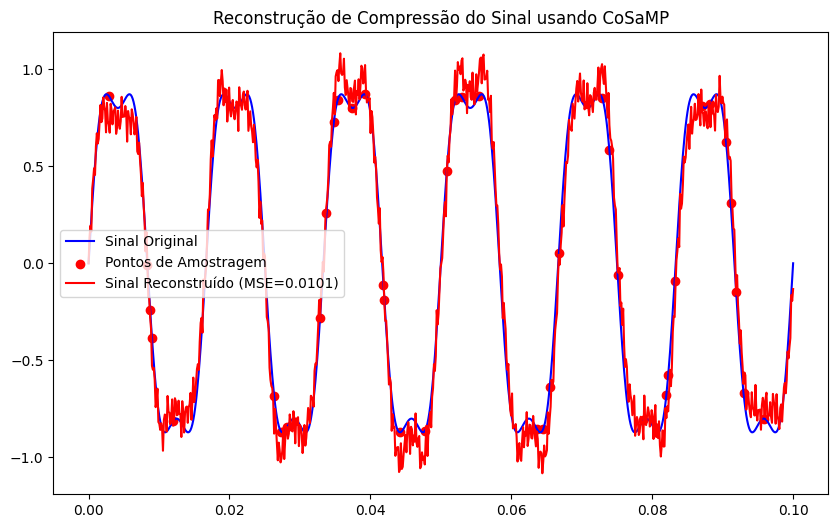

In [ ]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt

def cosamp(Phi, u, s, tol=1e-10, max_iter=10):
    max_iter -= 1  # Corrigir o loop while
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        y = np.abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2 * s] and val > num_precision]
        T = np.union1d(Omega, a.nonzero()[0])
        b = np.dot(np.linalg.pinv(Phi[:, T]), u)
        igood = (np.abs(b) > np.sort(np.abs(b))[::-1][s]) & (np.abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:, T], b[igood])

        halt = np.linalg.norm(v) / np.linalg.norm(u) < tol or \
               iter > max_iter

    return a

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed)**2)

n = 6*128  # número de medições
t = np.linspace(0.0, 0.1, num=n)

# Sinal original
x = np.sin(60* 2 * np.pi * t) + 0.2*np.sin(180 * 2 * np.pi * t)

# amostragem aleatória do sinal
p = 40  # amostragem aleatória (Note que isso é um oitavo da taxa de Shannon–Nyquist!)
amostras_aleatorias = np.round((n - 1) * np.random.rand(p)).astype(int)
y = x[amostras_aleatorias]  # nossa medição comprimida a partir da amostragem aleatória

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa

#Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
Phi = np.fft.fft(np.eye(n,n))
CPhi = np.imag(Phi[amostras_aleatorias, :])

# CoSaMP para minimização de l1
s_reconstruido_cosamp = cosamp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo CoSaMP
#x_rec_cosamp = scipy.fftpack.idct(s_reconstruido_cosamp, axis=0, norm='ortho')  # Sinal reconstruído
x_rec_cosamp = np.imag(np.fft.fft(s_reconstruido_cosamp))

# Calcular o MSE
mse_cosamp = calculate_mse(x, x_rec_cosamp)

# Visualizar o sinal original com pontos de amostragem aleatória e erro
plt.figure(figsize=(10, 6))
plt.plot(t, x, 'b', label='Sinal Original')
plt.scatter(t[amostras_aleatorias], x[amostras_aleatorias], color='red', label='Pontos de Amostragem')
plt.plot(t, x_rec_cosamp, 'r', label=f'Sinal Reconstruído (MSE={mse_cosamp:.4f})')
#plt.xlim(0.4, 0.5)
plt.title('Reconstrução de Compressão do Sinal usando CoSaMP')
plt.legend()
plt.show()
